### Union of CNN model and Deep Reinforcement Learning Model
The following code shows how the predictions of the two models built before can be combined to create a more robust model.

In [1]:
# libraries
from tensorflow import keras
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import scipy.io as sio
from scipy.fft import fft
import os
import matplotlib.pyplot as plt

In [3]:
# load the test X and y elements
with open('data/processed/trainX.npy', 'rb') as f:
    trainX = np.load(f)
with open('data/processed/trainy.npy', 'rb') as f:
    trainy = np.load(f)
with open('data/processed/testX.npy', 'rb') as f:
    testX = np.load(f)
with open('data/processed/testy.npy', 'rb') as f:
    testy = np.load(f)
with open('data/processed/valX.npy', 'rb') as f:
	valX = np.load(f)
with open('data/processed/valy.npy', 'rb') as f:
    valy = np.load(f)

In [3]:
# load ddqn model
ddqn_model = keras.models.load_model('models/ddqn_model_14.h5')

In [4]:
# load all cnn models and keep the one that gives the best results in a validation dataset
models_dir = 'models/'
cnn_models_paths = [filename for filename in os.listdir(models_dir) if filename.startswith('cnn_model')]
cnn_models = []
for cnn_model_path in cnn_models_paths:
    cnn_models.append((keras.models.load_model(models_dir+cnn_model_path)))

scores = []
for cnn_model in cnn_models:
    _, score = cnn_model.evaluate(valX, valy, verbose=0)
    scores.append(score)

best_model_index = np.argmax(scores)
cnn_model = cnn_models[best_model_index]

In [6]:
# CNN model prediction
pred_test_cnn = cnn_model.predict(testX)

test_acc_cnn = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test_cnn,axis=1))
print('Test accuracy for CNN model: ',test_acc_cnn)

330/330 [==============================] - 1s 3ms/step
Test accuracy for CNN model:  0.9391180654338549


In [6]:
# DDQN (CNN-RL) model prediction
pred_test_ddqn = ddqn_model.predict(testX)

test_acc_ddqn = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test_ddqn,axis=1))
print('Test accuracy for CNN-RL model: ',test_acc_ddqn)

330/330 [==============================] - 2s 6ms/step
Test accuracy for CNN-RL model:  0.8480796586059743


In [136]:
# Joint prediction of the two models

def join_predictions(pred_1,pred_2,w):
    """
    Function that takes in the predictions of two models and a weight and returns the joint predictions
    of the models using a weighted average of the predictions.
    """
    concat_preds = np.stack((pred_1, pred_2), axis=-1) # concatenate the predictions along the last dimension
    joint_preds = np.average(concat_preds, axis=2, weights=[w,1-w]) # calculate the weighted average of the predictions
    joint_pred_weighted = joint_preds*[0.6,1,1] # Give more weight to the faults than the healthy classes

    return joint_pred_weighted

# Initialize variables to keep track of the best weight and the corresponding accuracy
best_w = None
best_acc = 0

# Loop through different weight values and find the weight that gives the highest accuracy on the validation set
for w in np.arange(0,1.1,0.1):
    # get prediction of both models on validation set
    pred_cnn = cnn_model.predict(valX,verbose=0)
    pred_ddqn = ddqn_model.predict(valX,verbose=0)

    # get the joint prediction and accuracy with the current weight
    joint_preds = join_predictions(pred_cnn,pred_ddqn,w)
    acc_joint = accuracy_score(np.argmax(valy,axis=1), np.argmax(joint_preds,axis=1))

    if acc_joint > best_acc: # update the best weight and accuracy if needed
        best_w = w
        best_acc = acc_joint

# Print the best weight and the corresponding accuracy
print(best_w, ', ', best_acc)

0.7000000000000001 ,  0.9374110953058321


In [137]:
# Create joint model with the bet weight and perform prediction on test
joint_preds = join_predictions(pred_test_cnn, pred_test_ddqn, best_w)
test_acc_joint = accuracy_score(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1))
print('Test accuracy for union of both models: ',test_acc_joint)

Test accuracy for union of both models:  0.9402560455192034


In [138]:
# print a classification report to analyze different metrics in addition to accuracy

print(classification_report(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

# Recall is the model's ability to correctly detect all positive samples
# A high recall indicates that there are few false negatives
# With the joint model, the recall of the fault classes improved

              precision    recall  f1-score   support

     Healthy     0.9373    0.9558    0.9465      3552
    OR fault     0.9615    0.9514    0.9564      3600
    IR fault     0.9209    0.9122    0.9165      3393

    accuracy                         0.9403     10545
   macro avg     0.9399    0.9398    0.9398     10545
weighted avg     0.9403    0.9403    0.9402     10545



In [139]:
# Construct a visualization for the confusion matrix
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1))

# reformat the matrix
z_test[[0,2],:] = z_test[[2,0],:]

x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']

def format_text(z):
    """
    This function receives the confusion matrix values and formats the text
    to display in the matrix with the value and percentage of total data.
    """
    return f'{z}<br>({z / np.sum(z_test) * 100:.1f}%)'

z_text = np.vectorize(format_text)(z_test)

heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='cividis')
heatmap.update_layout(title_text='Joint Model',height=350,width=500,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show()

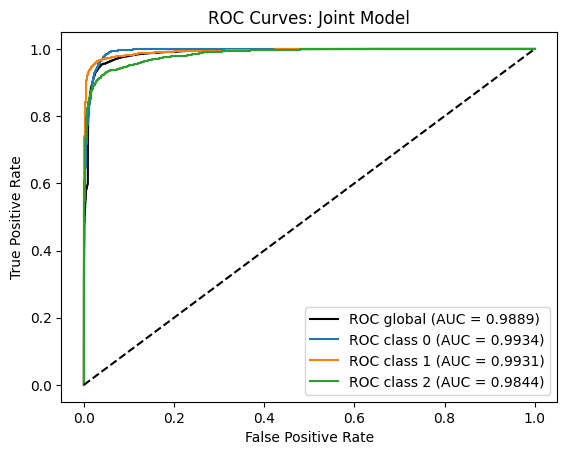

In [140]:
# Obtain ROC curve and AUC values for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], joint_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Get global ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), joint_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graph to show the global ROC curve and the ROC curves for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="ROC global (AUC = {:.4f})".format(roc_auc["micro"]), color="black")
for i in range(3):
    plt.plot(fpr[i], tpr[i], label="ROC class {} (AUC = {:.4f})".format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Joint Model")
plt.legend()
plt.show()
